In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")


print("Path to dataset files:", path)

/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


In [2]:
path

'/Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1'

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from PIL import Image
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path


In [46]:
# Configuration
PATCH_SIZE = 4
FRAGMENTS_PER_IMAGE = 16
EMBED_DIM = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-3
IMAGE_SIZE = 64
# cuda or mps or cpu
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [47]:
train_path = Path(path)/'train_64x64'/'train_64x64'
test_path = Path(path)/'valid_64x64/valid_64x64'
train_dataset_p = "tr_dataset.pt"
test_dataset_p = "te_dataset.pt"


In [49]:
class FragmentDataset(Dataset):
    def __init__(self, root,limit=None):

        self.images = []#[Image.open(x).convert("RGB") for x in Path(root).glob("*.png")]
        i = 0
        for x in tqdm(list(Path(root).glob("*.png"))):
            self.images.append(Image.open(x).convert("RGB"))
            i += 1
            if limit is not None and i >= limit:
                break

        #self.files = list(Path(root).glob("*.png"))  # or '*.jpg'
        self.transform = T.Compose([
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        try:
            img = self.transform(img)
        except Exception as e:
            print(f"Error transforming image {idx}: {e}")
            print(f"Image shape: {img.size}")

        fragments = []

        # Compute number of non-overlapping positions along H and W
        positions = []
        # For example, if IMAGE_SIZE=64 and PATCH_SIZE=4, we have 16 positions along each dimension
        # and 16 * 16 = 256 total positions
        for i in range(0, IMAGE_SIZE - PATCH_SIZE + 1, PATCH_SIZE):
            for j in range(0, IMAGE_SIZE - PATCH_SIZE + 1, PATCH_SIZE):
                positions.append((i, j))

        # Randomly sample without replacement
        #print(f"Positions: {positions}")
        selected_positions = random.sample(positions, FRAGMENTS_PER_IMAGE)

        for (i, j) in selected_positions:
            fragment = img[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            fragments.append(fragment)
        try:
            fragments = torch.stack(fragments)
        except Exception as e:
            print(f"Error stacking fragments for image {idx}: {e}")
            print(f"Fragment shapes: {[f.shape for f in fragments]}")

            # If stacking fails, return empty tensor
        return fragments, idx  # synthetic label

In [50]:
if Path(train_dataset_p).exists() and Path(test_dataset_p).exists():
    train_dataset = torch.load(train_dataset_p)
    test_dataset = torch.load(test_dataset_p)
else:
    test_dataset = FragmentDataset(test_path,limit=1000)
    torch.save(test_dataset, test_dataset_p)
    train_dataset = FragmentDataset(train_path,limit=20000)
    torch.save(train_dataset, train_dataset_p)

  2%|▏         | 19999/1281149 [00:11<11:34, 1815.08it/s]


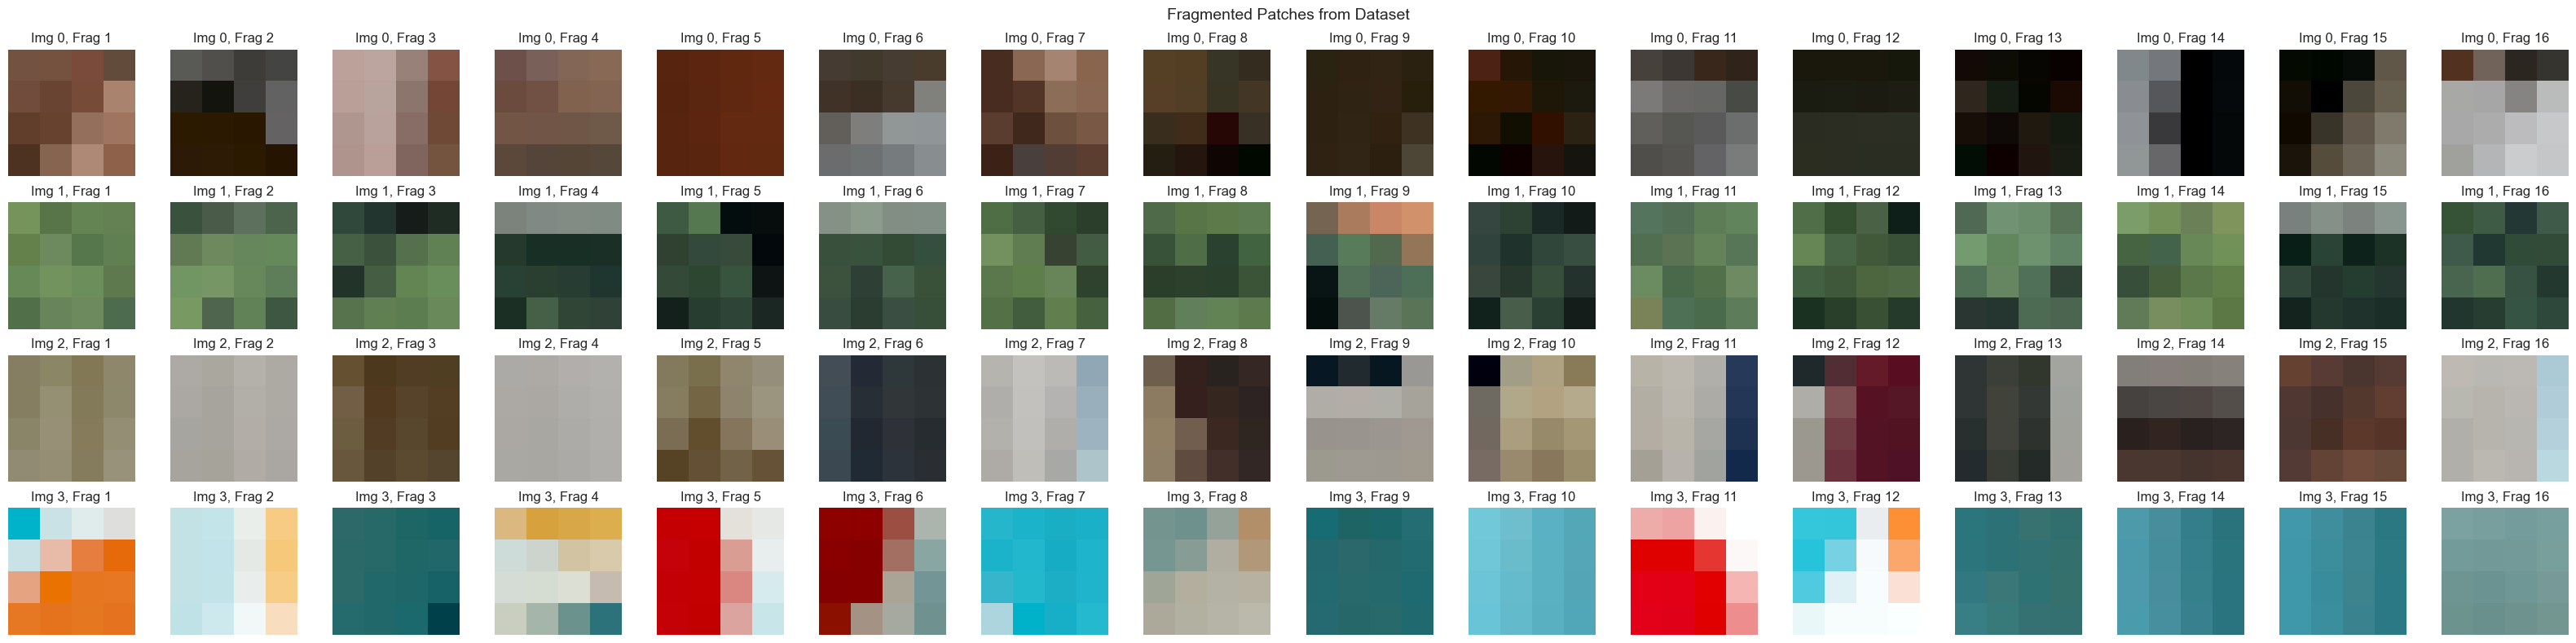

In [51]:
import matplotlib.pyplot as plt

# Visualise a few examples from the dataset
fig, axes = plt.subplots(4, FRAGMENTS_PER_IMAGE, figsize=(FRAGMENTS_PER_IMAGE * 2, 8))

for i in range(4):
    fragments, idx = train_dataset[i]
    for j in range(FRAGMENTS_PER_IMAGE):
        img = fragments[j].permute(1, 2, 0).numpy()  # CHW to HWC
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Img {idx}, Frag {j+1}")

plt.suptitle("Fragmented Patches from Dataset", fontsize=14)
plt.tight_layout()
plt.show()

In [52]:
import torchvision


class SimCLRProjectionHead(nn.Module):
    def __init__(self, input_dim=512, projection_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, projection_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', projection_dim=128):
        super().__init__()
        self.encoder = models.resnet18(weights='IMAGENET1K_V1')
        self.encoder.fc = nn.Identity()
        self.projection_head = SimCLRProjectionHead(input_dim=512, projection_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

class GlobalRelationTransformer(nn.Module):
    def __init__(self, embed_dim=128, patch_c=3, patch_h=4, patch_w=4, num_heads=4, num_layers=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(patch_c, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * patch_h * patch_w, embed_dim)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        # x: [B*N, C, H, W] — fully shuffled
        z = self.encoder(x)  # [B*N, D]
        z = z.unsqueeze(0)   # [1, B*N, D] for Transformer
        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)     # [B*N, D]
        return self.projector(z)



class ResNetTransformer(nn.Module):
    def __init__(self, embed_dim=128, transformer_layers=3, num_heads=4):
        super().__init__()

        # ResNet backbone (truncate final layer)
        backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])  # output: [B, 512, H', W']
        self.fc = nn.Linear(512, embed_dim)  # reduce to desired dim

        self.pos_embed = nn.Parameter(torch.randn(1, 1024, embed_dim))  # max 1024 patches
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):

        feat = self.encoder(x)  # [B*N, 512, H', W']
        #print("feat ", feat.shape)
        feat = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # [B*N, 512]
        #print("feat ", feat.shape)
        z = self.fc(feat)  # [B*N, embed_dim]
        #print("z ", z.shape)

        # Add position encoding
        z = z.unsqueeze(0)  # [1, B*N, D]
        #z = z + self.pos_embed[:, :z.size(1), :]  # make sure it's added correctly: [1, B*N, D]

        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)  # [B*N, D]
        return self.projector(z)  # [B*N, D



In [53]:
dataloader_train = DataLoader(train_dataset, batch_size=128, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [54]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import hdbscan
# Now safe to import sklearn/hdbscan/etc
from sklearn.metrics import adjusted_rand_score

def cluster_and_score(embeddings: torch.Tensor, true_labels: list[int]) -> float:
    """
    Perform HDBSCAN clustering and compute clustering accuracy via ARI.

    Args:
        embeddings (torch.Tensor): Tensor of shape [N, D], patch embeddings.
        true_labels (List[int]): Ground-truth image indices for each patch.

    Returns:
        ari (float): Adjusted Rand Index between predicted and true labels.
    """
    embeddings_np = embeddings.detach().cpu().numpy()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    pred_labels = clusterer.fit_predict(embeddings_np)
    true_labels = np.array(true_labels)
    # print("true_labels ", true_labels)
    # print("pred_labels ", pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return ari


def evaluate_clustering_on_validation( dataloader,model):
    """
    Evaluate clustering performance on validation set.
    Args:
        dataloader (DataLoader): DataLoader for validation set.
        model (nn.Module): Trained model for generating embeddings
    """
    ari_list = []
    for batch, labels in dataloader:
        batch = batch.to(DEVICE)
        with torch.no_grad():

            B, N, C, H, W = batch.shape

            # reshape to [B*N, C, H, W]

            true_labels = labels.numpy().repeat(N)
            #print("true_labels ", true_labels)
            batch = batch.view(B * N, C, H, W)
            embeddings = model(batch)
            #embeddings = embeddings.view(-1, embeddings.shape[-1])
            #print(embeddings.shape)
            # Compute ARI
            ari = cluster_and_score(embeddings, true_labels)
            ari_list.append(ari)
            #print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    # Average ARI over all batches
    avg_ari = np.mean(ari_list)
    return avg_ari
              # Only evaluate on the first batch for demonstration

evaluate_clustering_on_validation(dataloader_test,model)




np.float64(0.04905548155467512)

In [55]:

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Computes the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss.

    Args:
        z1, z2: Tensor of shape [B, D] - positive pairs of embeddings.
        temperature: Temperature scaling factor.

    Returns:
        Scalar loss (contrastive loss)
    """
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    representations = torch.cat([z1, z2], dim=0)  # [2B, D]
    similarity_matrix = torch.matmul(representations, representations.T)  # [2B, 2B]

    # remove self-similarity
    mask = torch.eye(2 * z1.shape[0], device=z1.device).bool()
    similarity_matrix.masked_fill_(mask, float('-inf'))

    # scale with temperature
    logits = similarity_matrix / temperature

    # positive pair targets: i-th sample should match with i+batch_size
    batch_size = z1.shape[0]
    targets = torch.cat([torch.arange(batch_size, device=z1.device) + batch_size,
                         torch.arange(batch_size, device=z1.device)], dim=0)

    loss = F.cross_entropy(logits, targets)
    return loss


def simple_contrastive_loss(z1, z2, margin=0.5):
    B = z1.size(0)

    # Normalize
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Positive similarity: same index
    sim_pos = F.cosine_similarity(z1, z2, dim=1)  # [B]
    positive_loss = 1 - sim_pos  # want close to 1

    # Negative similarity: all others
    sim_matrix = torch.matmul(z1, z2.T)  # [B, B]
    mask = ~torch.eye(B, dtype=torch.bool, device=z1.device)
    sim_neg = sim_matrix[mask]

    # Margin loss: push negatives below margin
    negative_loss = F.relu(sim_neg - margin).mean()

    # Total loss
    return positive_loss.mean() + negative_loss







# Hyperparameters
EPOCHS = 100
LR = 1e-4
#model = SimCLRModel(projection_dim=256).to(DEVICE)

#model = GlobalRelationTransformer(embed_dim=EMBED_DIM).to(DEVICE)
model = ResNetTransformer(transformer_layers=1,num_heads=1,embed_dim=EMBED_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max', factor=0.5, patience=5, verbose=True)


# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch, clases in tqdm(dataloader_train):
        B, N, C, H, W = batch.shape
        #print("batch shape ", batch.shape)
        batch = batch.view(B * N, C, H, W).to(DEVICE)
        labels = torch.arange(B).repeat_interleave(N).to(DEVICE)  # shape: [B*N]

        # Shuffle batch patches and labels together
        idx = torch.randperm(B * N)
        batch = batch[idx]
        labels = labels[idx]

        # Get embeddings for all shuffled patches: shape [B*N, D]
        all_embeddings = model(batch)
        #print("all_embeddings ", all_embeddings.shape)
        # Group embeddings by label, pick 2 per label to form positive pairs


        loss = None


        z1_list_lists, z2_list_list_lists = [], []


        for label in labels.unique():
            indices = (labels == label).nonzero(as_tuple=True)[0]

            if len(indices) < 2:
                continue  # skip if less than 2 patches for a class
            for ik in range(len(indices)//2):
                if len(z1_list_lists) < ik+1:
                    z1_list_lists.append([])
                    z2_list_list_lists.append([])


                chosen = indices[2*ik:2*ik+2]
                z1_list_lists[ik].append(all_embeddings[chosen[0]])
                z2_list_list_lists[ik].append(all_embeddings[chosen[1]])
        loss = None
        for i in range(len(z1_list_lists)):
            z1_list = z1_list_lists[i]
            z2_list = z2_list_list_lists[i]
            z1 = torch.stack(z1_list)  # [M, D]
            z2 = torch.stack(z2_list)  # [M, D]
            if loss is None:
                loss = simple_contrastive_loss(z1, z2)
                #loss = nt_xent_loss(z1, z2,0.3)
            else:
                #loss += nt_xent_loss(z1, z2,0.3)
                loss += simple_contrastive_loss(z1, z2)

        # Compute contrastive loss
        #loss = simple_contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_train)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    # Validation clustering
    model.eval()
    with torch.no_grad():
        avg_ari = evaluate_clustering_on_validation(dataloader_test, model)
        print(f"Epoch [{epoch + 1}/{EPOCHS}], ARI: {avg_ari:.4f}")
        lr_scheduler.step(avg_ari)
        print("Current LR:", lr_scheduler.get_last_lr())


/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  4%|▍         | 7/157 [00:05<01:58,  1.27it/s]


KeyboardInterrupt: 

🧠 Suggestions to Improve Clustering

1. Improve Training Signal
	•	Use a stronger contrastive loss, like NT-Xent (from SimCLR), with temperature scaling and softmax.
	•	Include hard negatives instead of random ones.
	•	Increase EPOCHS (50+), and possibly reduce learning rate gradually.

2. Embed More Patch Context
	•	Use larger patches or positional encoding to capture more spatial cues.
	•	Consider a Transformer or CNN with global receptive field.

3. More Patches per Image
	•	More fragment pairs during training allow the model to learn more consistent representations per source image.

4. Clustering Setup
	•	Try tuning min_cluster_size in HDBSCAN.
	•	Alternatively, try KMeans (if you roughly know the number of source images).

In [25]:
# now i want to debug

batch, idx= next(iter(dataloader_train))


images1 = batch[0]
print(images1.shape)
images2 = batch[1]

# now compute the embeddings
model.eval()
with torch.no_grad():
    embeddings1 = model(images1.to(DEVICE))
    embeddings2 = model(images2.to(DEVICE))
    # compute cosine similarity of embeddings
    print("embeddings ", embeddings1.shape)
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings1[2].unsqueeze(0))


    print("sim 0 vs 1:", sim.item())
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings2[6].unsqueeze(0))
    print("sim 0 vs 2:", sim.item())




torch.Size([8, 3, 4, 4])
embeddings  torch.Size([8, 256])
sim 0 vs 1: 0.06989866495132446
sim 0 vs 2: 0.27469900250434875


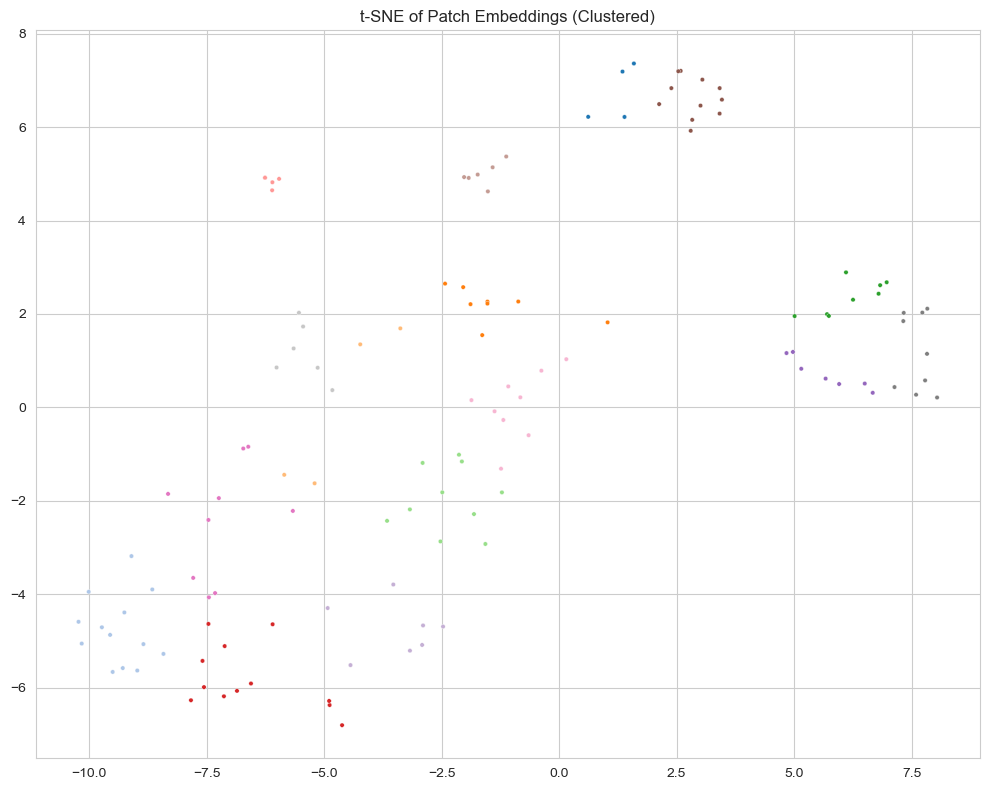

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm

# Reduce number of samples to avoid OOM
MAX_IMAGES = 4  # use fewer if needed
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for i, (batch, labels) in enumerate(dataloader_train):
        if len(all_labels) >= MAX_IMAGES * batch.size(1):
            break
        B, N, C, H, W = batch.shape
        batch = batch.view(B * N, C, H, W).to(DEVICE)
        emb = model(batch).cpu()
        all_embeddings.append(emb)
        all_labels.extend([i] * emb.size(0))

# Combine
embeddings = torch.cat(all_embeddings).numpy()
labels = all_labels[:len(embeddings)]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(embeddings)

# KMeans (optional)
kmeans = KMeans(n_clusters=16, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette="tab20", s=10, legend=False)
plt.title("t-SNE of Patch Embeddings (Clustered)")
plt.tight_layout()
plt.show()

  0%|          | 24/80072 [00:02<1:53:27, 11.76it/s]


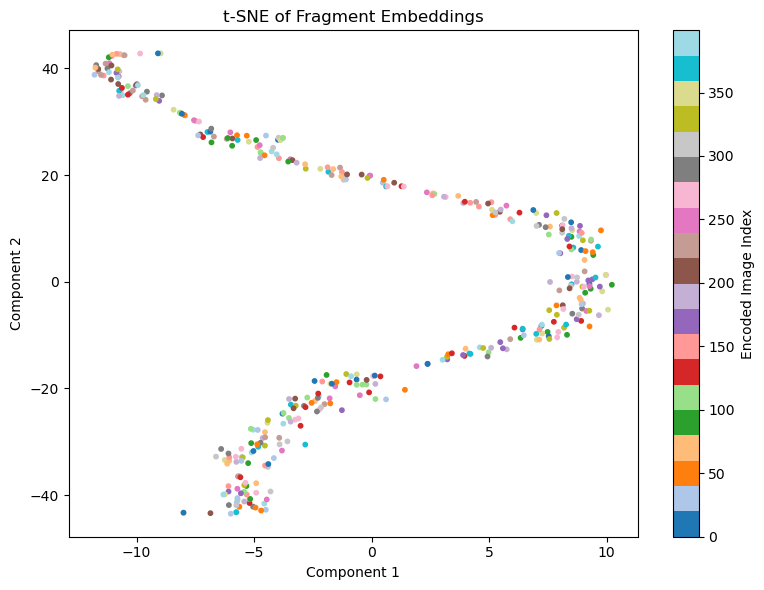

In [76]:
import torch
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()

# Storage for embeddings and labels
subset_embeddings = []
subset_labels = []

MAX_SAMPLES = 400  # or reduce if it's too slow

with torch.no_grad():
    for fragments, labels in tqdm(dataloader):
        fragments = fragments.to(DEVICE)

        # Collect until max sample limit
        if len(subset_labels) >= MAX_SAMPLES:
            break

        embeddings = model(fragments)
        subset_embeddings.append(embeddings.cpu())
        subset_labels.extend(labels.cpu().numpy())

        if len(subset_labels) >= MAX_SAMPLES:
            break

# Convert to numpy
embeddings = torch.cat(subset_embeddings, dim=0).numpy()
subset_labels = subset_labels[:MAX_SAMPLES]  # in case we went over

# --- Re-encode labels to 0 ... N-1 ---
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(subset_labels)

# --- Run t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# --- Plot ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=labels_encoded, cmap="tab20", s=10
)
plt.title("t-SNE of Fragment Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Encoded Image Index")
plt.tight_layout()
plt.show()

In [119]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [22]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch, clases in tqdm(dataloader_train):
        B, N, C, H, W = batch.shape
        batch = batch.view(B*N,C,H,W).to(DEVICE)
        labels = torch.arange(B).repeat_interleave(N)

        # shuffle batch patches and labels
        idx = torch.randperm(B*N)
        batch = batch[idx]
        labels = labels[idx]
        print("labels ", labels)

        # Get all fragment embeddings: output is [B, N, D]
        all_embeddings = model(batch)
        print("all_embeddings ", all_embeddings.shape)

        # Randomly select 2 different fragments per image → z1 and z2

        # here shoud be z1 and z2 which are selecred from all_embeddings that z1[i] and z2[i] are from the same image


        z1 = torch.stack([all_embeddings[i, idx1[i]] for i in range(B)])
        z2 = torch.stack([all_embeddings[i, idx2[i]] for i in range(B)])
       #print("z1 ", z1.shape)
        # Compute contrastive loss
        loss = simple_contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_train)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    # Validation clustering
    model.eval()
    with torch.no_grad():
        avg_ari = evaluate_clustering_on_validation(dataloader_test, model)
        print(f"Epoch [{epoch + 1}/{EPOCHS}], ARI: {avg_ari:.4f}")
        lr_scheduler.step(avg_ari)
        print("Current LR:", lr_scheduler.get_last_lr())

  0%|          | 0/500 [00:00<?, ?it/s]

labels  tensor([ 8,  6,  9, 12,  9,  5, 13,  8,  3,  6,  6,  1,  5,  4,  6,  0, 10, 13,
         0, 11,  0, 10,  8, 13,  7, 10,  9, 12, 15, 13, 14,  7,  0,  6, 14, 11,
         0, 11, 11,  4,  9,  9,  1, 15,  2,  4,  4,  2,  1,  3,  7, 14,  3, 13,
        10,  0,  2,  5,  9,  0,  2,  7, 12, 12, 15,  2,  8, 14,  3, 12,  8,  4,
         1,  2,  4,  8,  8,  9, 10,  3, 11,  2,  1,  7,  8,  1,  3, 14,  4, 14,
        10,  5, 15,  0, 10,  9,  3,  1,  2, 12,  6,  7,  4,  3, 14, 15, 13, 15,
         1, 14, 10,  5, 11, 12,  5,  7, 12,  5,  5, 11, 13,  6, 11,  7, 13,  6,
        15, 15])
all_embeddings  torch.Size([128, 256])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [23]:
# Training loop


100%|██████████| 500/500 [00:38<00:00, 12.94it/s]


Epoch [1/100], Loss: 0.4994
Epoch [1/100], ARI: 0.0418
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.42it/s]


Epoch [2/100], Loss: 0.5000
Epoch [2/100], ARI: 0.0416
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.40it/s]


Epoch [3/100], Loss: 0.5000
Epoch [3/100], ARI: 0.0503
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.57it/s]


Epoch [4/100], Loss: 0.5000
Epoch [4/100], ARI: 0.0475
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.53it/s]


Epoch [5/100], Loss: 0.4999
Epoch [5/100], ARI: 0.0462
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.38it/s]


Epoch [6/100], Loss: 0.5000
Epoch [6/100], ARI: 0.0486
Current LR: [0.001]


100%|██████████| 500/500 [00:34<00:00, 14.59it/s]


Epoch [7/100], Loss: 0.5000
Epoch [7/100], ARI: 0.0476
Current LR: [0.001]


100%|██████████| 500/500 [00:33<00:00, 14.77it/s]


Epoch [8/100], Loss: 0.5000
Epoch [8/100], ARI: 0.0510
Current LR: [0.001]


 90%|████████▉ | 448/500 [00:30<00:03, 14.58it/s]


KeyboardInterrupt: 